In [1]:
import torch
import torchvision
import PIL
import os
from matplotlib import pyplot as plt
import cv2
import random
import warnings
import timm
from torch import nn
import numpy as np
from tqdm import tqdm_notebook
from torchvision.models import mobilenet_v3_small
from torchsummary import summary
import glob

import seaborn as sb
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix


warnings.filterwarnings('ignore')

device='cuda' if torch.cuda.is_available() else 'cpu'

print(f'Using: {device}')


Using: cuda


In [2]:
model=mobilenet_v3_small(weights='DEFAULT')
model.classifier[3]=nn.Linear(in_features=1024,out_features=2,bias=True)

In [3]:
model

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [4]:
class dataset(torch.utils.data.Dataset):
    def __init__(self,src=None,paths=None):
        if src is not None:
            self.src=src
            self.images=os.listdir(src)
            
        else:
            self.src=None
            self.images=paths

        self.transforms=torchvision.models.MobileNet_V3_Small_Weights.IMAGENET1K_V1.transforms()
    
    def __len__(self):
        return len(self.images)


    def __getitem__(self,idx):
        if self.src is not None:
            img=cv2.imread(self.src+"/"+self.images[idx])
        else:
            img=cv2.imread(self.images[idx])
          
        pixelize=random.randint(0,1)

        
        t_lower = 50  # Lower Threshold 
        t_upper = 150  # Upper threshold 
        '''
        edge = cv2.Canny(img, t_lower, t_upper) 
        '''
        
        downsize=random.randint(0,1)

        if(downsize):
                image=img
                
                original_height, original_width = image.shape[:2]

                alpha = 2.0
                beta = 5.0
                
                random_beta = np.random.beta(alpha, beta)
                
                random_number = 1.6 + random_beta * (3 - 1.6)
                
                scale_factor = round(random_number, 1)


                new_width = int(original_width // scale_factor)
                new_height = int(original_height // scale_factor)  
                
                downscaled_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_NEAREST)
            
                upscaled_image = torch.from_numpy(cv2.resize(downscaled_image, (original_width, original_height), interpolation=cv2.INTER_NEAREST)).permute(2,0,1)

                return self.transforms(upscaled_image), torch.tensor([0,1]).type(torch.float32)
                          
        else:
                return self.transforms(torch.from_numpy(img).permute(2,0,1)),torch.tensor([1,0]).type(torch.float32)
        

In [5]:
path='../../../coco_sample/train_sample/'
paths = glob.glob(path + "/*.jpg")

np.random.seed(123)
paths_subset = np.random.choice(paths, 14_000, replace=False) 
rand_idxs = np.random.permutation(14_000)
train_idxs = rand_idxs[:8000] 
val_idxs = rand_idxs[8000:10000] 
test_idxs = rand_idxs[10000:]
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]
test_paths = paths_subset[test_idxs]

In [6]:
train_ds=dataset(paths=train_paths)
val_ds=dataset(paths=val_paths)
test_ds=dataset(paths=test_paths)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])
torch.FloatTensor
tensor([0., 1.])


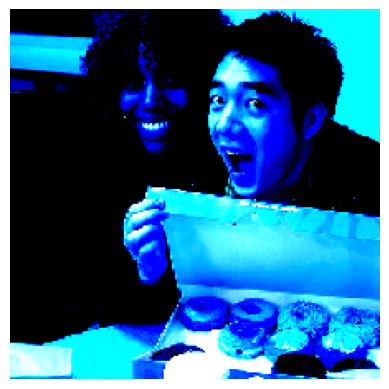

In [7]:
plt.axis(False)
t=train_ds.__getitem__(torch.randint(0,1000,(1,)))
print(t[0].shape)
print(t[0].type())
plt.imshow(t[0].permute(1,2,0))
print(t[1])

In [8]:
torchvision.models.MobileNet_V3_Small_Weights.IMAGENET1K_V1.transforms()

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [9]:
train_loader=torch.utils.data.DataLoader(train_ds,16,shuffle=True)
val_loader=torch.utils.data.DataLoader(val_ds,16,shuffle=True)
test_loader=torch.utils.data.DataLoader(test_ds,16,shuffle=True)

In [10]:
x,y=next(iter(train_loader))

In [11]:
x,y=next(iter(train_loader))
print(x.shape)
output=torch.argmax(torch.softmax(model(x),dim=1),dim=1)
output

torch.Size([16, 3, 224, 224])


tensor([0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1])

In [12]:
y

tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]])

In [13]:
loss_fn=nn.CrossEntropyLoss()

In [14]:
with torch.inference_mode():
    logits=model(x)
    torch.eq(torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze(),torch.argmax(y,dim=1)).sum().item()/len(logits)
    print(loss_fn(torch.squeeze(logits,dim=1),y))

tensor(0.7172)


In [15]:
model=model.to(device)

In [23]:
def accuracy_fn(logits,true):
    return torch.eq(torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze(),true).sum().item()/len(logits)

def train_model(model,epochs):
    optimizer=torch.optim.Adam(params=model.parameters())
    loss_fn=nn.CrossEntropyLoss()
    
    max_acc=0
    for i in tqdm_notebook(range(epochs)):
        train_preds=torch.tensor([])
        val_preds=torch.tensor([])
        train_actual=torch.tensor([])
        val_actual=torch.tensor([])
        
        print("\nTraining:")
        model.train()
        
        #Defining accuracy and loss for train and val data
        temp_train_accuracy=[]
        temp_val_accuracy=[]
        temp_train_loss=[]
        temp_val_loss=[]
      
        net_train_accuracy=0
        net_val_accuracy=0
        net_train_loss=0
        net_val_loss=0
        
        with tqdm_notebook(total=len(train_loader)) as pbar:
            for x,y in train_loader:
                    x=x.to(device)
                    y=y.to(device)
        
                    #Calculating model output
                    logits=model(x)
        
                    #Reseting any old gradient values
                    optimizer.zero_grad()
                    loss=loss_fn(torch.squeeze(logits,dim=1),y)
                
                    #Track of metrics
                    preds=torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze()
                    accuracy_train=accuracy_fn(logits.type(torch.float32),torch.argmax(y,dim=1))
                    temp_train_accuracy.append(accuracy_train)
                    temp_train_loss.append(loss.item())
                
                    #Back Propogation
                    loss.backward()
                
                    #Update Parameters
                    optimizer.step()
                
                    #Progress Bar Update
                    pbar.update(1)
            pbar.close()
        net_train_accuracy=sum(temp_train_accuracy)/len(temp_train_accuracy)
        net_train_loss=sum(temp_train_loss)/len(temp_train_loss)
    
        #Evaluation
        print("Testing:")
        model.eval()

        
    
        with tqdm_notebook(total=len(val_loader)) as pbar2:
            for x,y in val_loader:
                x=x.to(device)
                y=y.to(device)
                
                #Setting inference mode
                with torch.inference_mode():
                    logits=model(x)
                    loss=loss_fn(torch.squeeze(logits,dim=1),y.type(torch.float32))
                    
                    #Track of metrics
                    preds=torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze()
                    accuracy_val=accuracy_fn(logits,torch.argmax(y,dim=1))
                    temp_val_accuracy.append(accuracy_val)
                    temp_val_loss.append(loss.item())
        
                    #Progress Bar Update
                    pbar2.update(1)
            pbar2.close()
    
        net_val_accuracy=sum(temp_val_accuracy)/len(temp_val_accuracy)
        net_val_loss=sum(temp_val_loss)/len(temp_val_loss)
     
        if(net_val_accuracy>max_acc):
            if(max_acc!=0):
                os.remove(f'method1({max_acc:.3f}).pt')
            max_acc=net_val_accuracy
            print(f'Saving model')
            torch.save(model.state_dict(),f'method1({net_val_accuracy:.3f}).pt')
        
        print(f"\nEpoch {i+1}:\n\nTrain Accuracy: {net_train_accuracy}\n\nTrain Loss: {net_train_loss}\n\nVal Accuracy: {net_val_accuracy}\n\nVal Loss: {net_val_loss}")


def test_model(model):
    optimizer=torch.optim.Adam(params=model.parameters())
    loss_fn=nn.CrossEntropyLoss()
    
    test_preds=torch.tensor([])
    test_actual=torch.tensor([])

    
    predictions=[]
    targets=[]
    
    temp_test_accuracy=[]
    temp_test_loss=[]

    net_test_accuracy=0
    net_test_loss=0

    #Evaluation
    print("Testing:")
    model.eval()

    

    with tqdm_notebook(total=len(test_loader)) as pbar2:
        for x,y in test_loader:
            x=x.to(device)
            y=y.to(device)
            
            #Setting inference mode
            with torch.inference_mode():
                logits=model(x)
                loss=loss_fn(torch.squeeze(logits,dim=1),y.type(torch.float32))
                
                #Track of metrics
                preds=torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze()
                accuracy_test=accuracy_fn(logits,torch.argmax(y,dim=1))
                temp_test_accuracy.append(accuracy_test)
                temp_test_loss.append(loss.item())
                predictions.extend(torch.argmax(torch.softmax(logits,dim=1),dim=1).tolist())
                targets.extend(torch.argmax(y, dim=1).tolist())

                #Progress Bar Update
                pbar2.update(1)
                
                
        pbar2.close()

    

    conf_matrix = confusion_matrix(targets, predictions)

    # Calculate precision, recall, and F1 score
    precision = precision_score(targets, predictions)
    recall = recall_score(targets, predictions)
    f1 = f1_score(targets, predictions)
    
    print("Confusion Matrix:")
    print("\nPrecision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    
    net_test_accuracy=sum(temp_test_accuracy)/len(temp_test_accuracy)
    net_test_loss=sum(temp_test_loss)/len(temp_test_loss)

    print(f"Test Accuracy: {net_test_accuracy}\nTest Loss: {net_test_loss}")

    plt.figure(figsize=(10, 7))
    sb.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pixelated'], yticklabels=['Normal', 'Pixelated'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [17]:
train_model(model,20)

  0%|          | 0/20 [00:00<?, ?it/s]


Training:


  0%|          | 0/500 [00:00<?, ?it/s]

Testing:


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model

Epoch 1:

Train Accuracy: 0.854125

Train Loss: 0.33926426830142736

Val Accuracy: 0.8885

Val Loss: 0.31675114354491235

Training:


  0%|          | 0/500 [00:00<?, ?it/s]

Testing:


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model

Epoch 2:

Train Accuracy: 0.90625

Train Loss: 0.23244218335859476

Val Accuracy: 0.9345

Val Loss: 0.17303925412148238

Training:


  0%|          | 0/500 [00:00<?, ?it/s]

Testing:


  0%|          | 0/125 [00:00<?, ?it/s]


Epoch 3:

Train Accuracy: 0.9285

Train Loss: 0.1846886154874228

Val Accuracy: 0.7425

Val Loss: 0.8664641991853714

Training:


  0%|          | 0/500 [00:00<?, ?it/s]

Testing:


  0%|          | 0/125 [00:00<?, ?it/s]


Epoch 4:

Train Accuracy: 0.932

Train Loss: 0.17646483160601928

Val Accuracy: 0.644

Val Loss: 0.8490630568265914

Training:


  0%|          | 0/500 [00:00<?, ?it/s]

Testing:


  0%|          | 0/125 [00:00<?, ?it/s]


Epoch 5:

Train Accuracy: 0.948625

Train Loss: 0.14101262169051915

Val Accuracy: 0.9025

Val Loss: 0.22948544409871102

Training:


  0%|          | 0/500 [00:00<?, ?it/s]

Testing:


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model

Epoch 6:

Train Accuracy: 0.9575

Train Loss: 0.11848785465955734

Val Accuracy: 0.9515

Val Loss: 0.17225174923799932

Training:


  0%|          | 0/500 [00:00<?, ?it/s]

Testing:


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model

Epoch 7:

Train Accuracy: 0.9565

Train Loss: 0.12409212468308396

Val Accuracy: 0.959

Val Loss: 0.13147601977735757

Training:


  0%|          | 0/500 [00:00<?, ?it/s]

Testing:


  0%|          | 0/125 [00:00<?, ?it/s]


Epoch 8:

Train Accuracy: 0.961875

Train Loss: 0.1070395551964175

Val Accuracy: 0.788

Val Loss: 0.7301104615926742

Training:


  0%|          | 0/500 [00:00<?, ?it/s]

Testing:


  0%|          | 0/125 [00:00<?, ?it/s]


Epoch 9:

Train Accuracy: 0.96225

Train Loss: 0.10444188303162809

Val Accuracy: 0.9545

Val Loss: 0.1425438798237592

Training:


  0%|          | 0/500 [00:00<?, ?it/s]

Testing:


  0%|          | 0/125 [00:00<?, ?it/s]


Epoch 10:

Train Accuracy: 0.9645

Train Loss: 0.10062830592200044

Val Accuracy: 0.867

Val Loss: 0.29230679784715174

Training:


  0%|          | 0/500 [00:00<?, ?it/s]

Testing:


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model

Epoch 11:

Train Accuracy: 0.96575

Train Loss: 0.10144205883640098

Val Accuracy: 0.9725

Val Loss: 0.07677979711070657

Training:


  0%|          | 0/500 [00:00<?, ?it/s]

Testing:


  0%|          | 0/125 [00:00<?, ?it/s]


Epoch 12:

Train Accuracy: 0.965

Train Loss: 0.09999436058173887

Val Accuracy: 0.913

Val Loss: 0.30108946971502154

Training:


  0%|          | 0/500 [00:00<?, ?it/s]

Testing:


  0%|          | 0/125 [00:00<?, ?it/s]


Epoch 13:

Train Accuracy: 0.967

Train Loss: 0.09557668980106246

Val Accuracy: 0.944

Val Loss: 0.14525845140218735

Training:


  0%|          | 0/500 [00:00<?, ?it/s]

Testing:


  0%|          | 0/125 [00:00<?, ?it/s]


Epoch 14:

Train Accuracy: 0.96875

Train Loss: 0.09025192003767006

Val Accuracy: 0.9425

Val Loss: 0.1846151492591016

Training:


  0%|          | 0/500 [00:00<?, ?it/s]

Testing:


  0%|          | 0/125 [00:00<?, ?it/s]


Epoch 15:

Train Accuracy: 0.967

Train Loss: 0.09026858846540563

Val Accuracy: 0.9655

Val Loss: 0.10032441567070782

Training:


  0%|          | 0/500 [00:00<?, ?it/s]

Testing:


  0%|          | 0/125 [00:00<?, ?it/s]


Epoch 16:

Train Accuracy: 0.970375

Train Loss: 0.08480869250030082

Val Accuracy: 0.948

Val Loss: 0.16700240435515298

Training:


  0%|          | 0/500 [00:00<?, ?it/s]

Testing:


  0%|          | 0/125 [00:00<?, ?it/s]


Epoch 17:

Train Accuracy: 0.97075

Train Loss: 0.0829529107354465

Val Accuracy: 0.86

Val Loss: 0.38203465919196605

Training:


  0%|          | 0/500 [00:00<?, ?it/s]

Testing:


  0%|          | 0/125 [00:00<?, ?it/s]


Epoch 18:

Train Accuracy: 0.970625

Train Loss: 0.08043845135328592

Val Accuracy: 0.9475

Val Loss: 0.14630926406383515

Training:


  0%|          | 0/500 [00:00<?, ?it/s]

Testing:


  0%|          | 0/125 [00:00<?, ?it/s]

Saving model

Epoch 19:

Train Accuracy: 0.972875

Train Loss: 0.08171184092527256

Val Accuracy: 0.9735

Val Loss: 0.07751588013512083

Training:


  0%|          | 0/500 [00:00<?, ?it/s]

Testing:


  0%|          | 0/125 [00:00<?, ?it/s]


Epoch 20:

Train Accuracy: 0.97525

Train Loss: 0.06919001912212115

Val Accuracy: 0.9675

Val Loss: 0.10130725080147386


Testing:


  0%|          | 0/250 [00:00<?, ?it/s]

Confusion Matrix:

Precision: 0.9893390191897654
Recall: 0.9317269076305221
F1 Score: 0.9596690796277145
Test Accuracy: 0.961
Test Loss: 0.12647114165042878


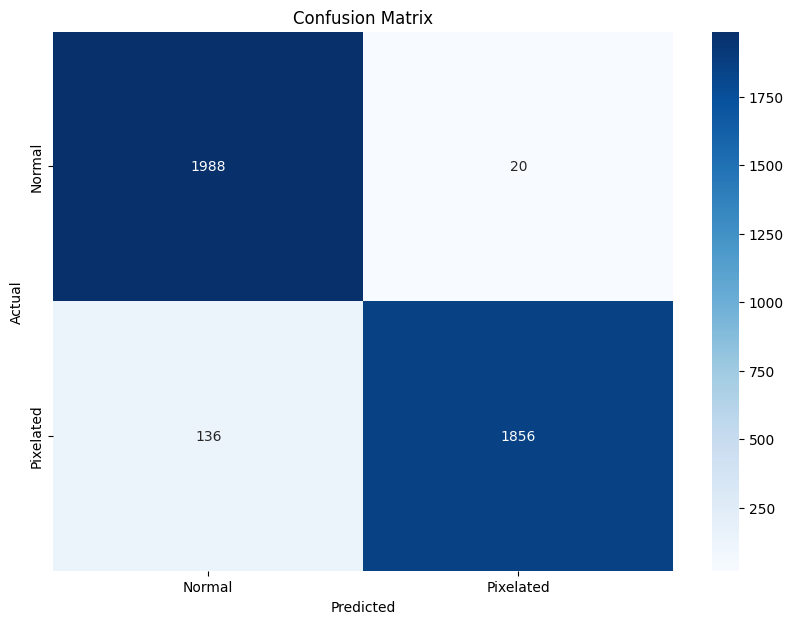

In [25]:
model.load_state_dict(torch.load('method1(0.974).pt'))
test_model(model)

In [26]:
x,y=next(iter(val_loader))
x=x.to(device)
y=y.to(device)

In [27]:
with torch.inference_mode():
    output=torch.argmax(torch.softmax(model(x),dim=1),dim=1)
    print(output)

tensor([1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0], device='cuda:0')


In [28]:
torch.argmax(y,dim=1)

tensor([1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')

In [29]:
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 5.844MB
